In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# gpu 메모리 최대로 잡는 것을 방지
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

model = load_model('C:/Users/s_csmscox/jupyterSave/eye_blink/eye_blink_CNN.h5')

1 Physical GPUs, 1 Logical GPUs


# CascadeClassifier 이용

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

face_cascade = cv2.CascadeClassifier('C:/Users/s_csmscox/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:/Users/s_csmscox/anaconda3/Lib/site-packages/cv2/data/haarcascade_eye.xml')

img = cv2.imread('./face.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.show()

In [ ]:
# 눈 찾아내기

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        img_trim = img[y+ey:y+ey+eh, x+ex:x+ex+ew]
        
        
plt.imshow(img_trim)
plt.show()

In [ ]:
# 예측

from PIL import Image

img_size =32
img_trim = Image.fromarray(img_trim)
img_trim = img_trim.resize((img_size, img_size))
img_trim = np.asarray(img_trim)

plt.imshow(img_trim)
plt.show()

img_trim = img_trim/255

img_trim = img_trim.reshape(1,img_size,img_size,3)
pred = model.predict(img_trim)

if np.argmax(pred) == 0:
    print("예측 : 졸음")
else:
    print("예측 : 안졸음")

# dlib - Face Landmark 이용

In [3]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
from matplotlib import pyplot as plt
from PIL import Image

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('C:/Users/s_csmscox/jupyterSave/eye_blink/shape_predictor_68_face_landmarks.dat')

img_size = (32, 32)

def crop_eye(img, eye_points):
    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    
    w = (x2 - x1) * 1.2
    h = w * img_size[1] / img_size[0]
    
    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

    eye_img = img[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]
    
    return eye_img, eye_rect

img = cv2.imread('./face.jpg')

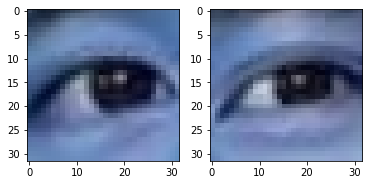

In [4]:
faces = detector(img)

fig = plt.figure()
rows = 1
cols = 2

for face in faces:
    shapes = predictor(img, face)
    shapes = face_utils.shape_to_np(shapes)
    
    eye_img_l, eye_rect_l = crop_eye(img, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(img, eye_points=shapes[42:48])
    
    eye_img_l = cv2.resize(eye_img_l, dsize=img_size)
    eye_img_r = cv2.resize(eye_img_r, dsize=img_size)
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(eye_img_l)
    
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(eye_img_r)
    
    plt.show()


In [5]:
# 왼쪽 눈
eye_input_l = eye_img_l.copy().reshape((1, img_size[1], img_size[0], 3)).astype(np.float32)
eye_input_l = eye_input_l/255

pred_l = model.predict(eye_input_l)

# 오른쪽 눈
eye_input_r = eye_img_r.copy().reshape((1, img_size[1], img_size[0], 3)).astype(np.float32)
eye_input_r = eye_input_r/255

pred_r = model.predict(eye_input_r)

# 두 눈 다 감은 경우 졸음으로 예측
if np.argmax(pred_l) == 0 and np.argmax(pred_r) == 0:
    print("예측 : 졸음")
else:
    print("예측 : 안졸음")

예측 : 안졸음


In [9]:
cap = cv2.VideoCapture('C:/Users/s_csmscox/jupyterSave/eye_blink/face2.mp4')

n_count = 0

while True:
#     frame_pos = cap.get(cv2.CAP_PROP_POS_FRAMES)
#     frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    
#     print("%d/%d" %(frame_pos, frame_count))
    ret, img_ori = cap.read()

    if not ret:
        break

    img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

    img = img_ori.copy()

    faces = detector(img)

    for face in faces:
        shapes = predictor(img, face)
        shapes = face_utils.shape_to_np(shapes)

        eye_img_l, eye_rect_l = crop_eye(img, eye_points=shapes[36:42])
        eye_img_r, eye_rect_r = crop_eye(img, eye_points=shapes[42:48])

        eye_img_l = cv2.resize(eye_img_l, dsize=img_size)
        eye_img_r = cv2.resize(eye_img_r, dsize=img_size)

        # 왼쪽 눈
        eye_input_l = eye_img_l.copy().reshape((1, img_size[1], img_size[0], 3)).astype(np.float32)
        eye_input_l = eye_input_l/255

        pred_l = model.predict(eye_input_l)
        pred_l = np.argmax(pred_l)

        # 오른쪽 눈
        eye_input_r = eye_img_r.copy().reshape((1, img_size[1], img_size[0], 3)).astype(np.float32)
        eye_input_r = eye_input_r/255

        pred_r = model.predict(eye_input_r)
        pred_r = np.argmax(pred_r)

        # 두 눈 다 감은 경우 졸음으로 예측
        if pred_l == 0 and pred_r == 0:
            n_count += 1
        else:
            n_count = 0


        if n_count > 10:
            # BGR
            cv2.putText(img,"Wake up", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)


        # visualize
#         state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
#         state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

#         state_l = state_l % pred_l
#         state_r = state_r % pred_r


        cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
        cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

        cv2.putText(img, str(pred_l), tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        cv2.putText(img, str(pred_r), tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

    cv2.imshow('result', img)
    
    if cv2.waitKey(33) > 0:
        break

cap.release()
cv2.destroyAllWindows()